# Primitives basics

There are currently 2 supported Qiskit primitives: **Sampler** and **Estimator**.

1) **Sampler**: Calculate the quasi-probabilities of bitstrings form quantum circuits.
    - Quantum circuits $\psi_i(\theta)$.
    - Parameter values: $\theta_k$.


2) **Estimator**: Estimate expectation values of quantum circuits and observables. 
    - Quantum circuits $\psi_i(\theta)$. A list of (parameterized) quantum circuits.
    - Observables $H_j$.
    - Parameter values $\theta_k$. A list of values to be bound to the parameters of th quantum circuits.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator, Sampler
from qiskit.visualization import plot_histogram

with open('../api_key.txt', 'r') as file:
    token = file.read()

service = QiskitRuntimeService(channel="ibm_quantum",token=token)

warnings.simplefilter(action='ignore', )

In [24]:
def backend_information(backend):
    print('Configuration:')
    print('  Name: ', backend.configuration().backend_name)
    print('  Version: ', backend.configuration().backend_version)
    print('  N-Qubits: ', backend.configuration().n_qubits)
    print('  Basis Gates: ',backend.configuration().basis_gates)
    print('Status:')
    print('  Operational: ', backend.status().operational)
    print('  Pending jobs:', backend.status().pending_jobs)
    print('  Status message:', backend.status().status_msg)

### 1) Sampler

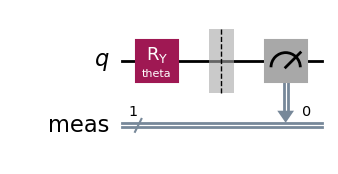

In [25]:
# Lets create a parameterized Quantum Circuit using the Ry gate and measuring all qubits.
theta = Parameter('theta')

qc = QuantumCircuit(1)
qc.ry(theta,0)
qc.measure_all()
qc.draw("mpl")


In [26]:
# Define a set of parameters from 0 to 2 pi as list of lists
phases = np.linspace(0,2*np.pi,100)
individual_phases = [[ph] for ph in phases]


### Local execution on Aer Backend

In [27]:
# Evaluate the QC for every parameter using the sampler primitive
aer_sampler = AerSampler()
result = aer_sampler.run(
    [qc]*len(individual_phases),
    parameter_values = individual_phases
).result()


In [28]:
# Gather the results
# The probablity of measuring |0> for each theta
prob_values_0 = [dist.get(0, 0) for dist in result.quasi_dists]
# The probablity of measuring |1> for each theta
prob_values_1 = [dist.get(1, 0) for dist in result.quasi_dists]


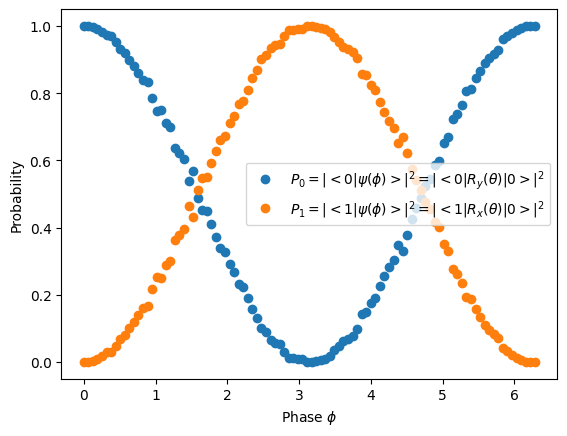

In [29]:
plt.plot(phases, prob_values_0, 'o', label=r'$P_0 = |<0|\psi(\phi)>|^2 = |<0|R_y(\theta)|0>|^2$')
plt.plot(phases, prob_values_1, 'o', label=r'$P_1 = |<1|\psi(\phi)>|^2 = |<1|R_x(\theta)|0>|^2$')
plt.xlabel(r'Phase $\phi$')
plt.ylabel(r'Probability')
plt.legend()

### Execution on local fake provider (Quantum Simulator)

We first need to instantiate the backend.

In [30]:
service = QiskitRuntimeService(channel='ibm_quantum', token=token)
real_backend = service.least_busy(
    min_num_qubits=5,
    operational=True,
    simulator=False
)

backend_information(real_backend)

Configuration:
  Name:  ibm_brisbane
  Version:  1.1.41
  N-Qubits:  127
  Basis Gates:  ['ecr', 'id', 'rz', 'sx', 'x']
Status:
  Operational:  True
  Pending jobs: 117
  Status message: active


Now we establish a fake backend that mimics the configuration (layout and noise) of the real backend.

In [31]:
fake_backend = AerSimulator.from_backend(real_backend)
fake_backend

AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['sx', 'reset', 'ecr', 'measure', 'x', 'id']>)

Before we can execute the circuit we need to transpile it to the ISA of the underlying hardware system.

In [32]:
pm = generate_preset_pass_manager(backend=fake_backend, optimization_level=3)
isa_qc = pm.run(qc)

In [33]:
# Sample the isa quantum circuit using the Qiskit Runtime Session and the Sampler primitive.
# Use the 'individual_phases' as parameter sweep
# Extract the result as 'result_fake'

# Your code goes here:


In [34]:
prob_values_0_fake = [dist.get(0, 0) for dist in result_fake.quasi_dists]
# The probablity of measuring |1> for each theta
prob_values_1_fake = [dist.get(1, 0) for dist in result_fake.quasi_dists]

NameError: name 'result_fake' is not defined

: 

### Execution on real IBM-Quantum devices

We have already instantiated our backend.

Lets verify this information on the [IBM-Quantum-Platform](https://quantum-computing.ibm.com/)

We can now use this backend similar to how we used the Simulator backend via the cloud: just specify the real backend as backend.

In [ ]:
real_backend

In [ ]:
with Session(service=service,backend=real_backend) as session:
    sampler = Sampler(session=session)
    job = sampler.run(circuits=[isa_qc]*len(individual_phases),
            parameter_values=individual_phases)
job

In [ ]:
# Retrieve the results of your job: 

# job = service.job('csy0hfd8cwag008wpp4g')
# result_real = job.result()

In [ ]:
# Gather the results
# The probablity of measuring |0> for each theta
prob_values_0_real = [dist.get(0, 0) for dist in result_real.quasi_dists]
# The probablity of measuring |1> for each theta
prob_values_1_real = [dist.get(1, 0) for dist in result_real.quasi_dists]

In [ ]:
plt.plot(phases, prob_values_0, '-o', label=r'$P_0 - Simulator$')
plt.plot(phases, prob_values_1, '-o', label=r'$P_1 - Simulator$')
plt.plot(phases, prob_values_0_fake, '--', label=r'$P_0 - Fake$')
plt.plot(phases, prob_values_1_fake, '--', label=r'$P_1 - Fake$')
plt.plot(phases, prob_values_0_real, '-*', label=r'$P_0 - Real$')
plt.plot(phases, prob_values_1_real, '-*', label=r'$P_1 - Real$')
plt.xlabel(r'Phase $\phi$')
plt.ylabel(r'Probability')
plt.legend()

**Note**: All evaluations for the the whole range of parameters will be executed in one go. This is the power of **Primitives** and **Sessions**